# MLE 2023 Workshop Notebook

This notebook contains a template for the joint exercise regarding physics informed deep learning and TorchPhysics.

We start by solving the Laplace equation:

\begin{align*}
    \Delta u &= 1 &&\text{ in } \Omega \\
    u &= 0 , &&\text{ on } \partial \Omega
\end{align*}

with $\Omega = [0, 1] \times [0, 1]$.

First we have to install the library:

In [1]:
!pip install torchaudio==0.13.0
!pip install torchphysics

import torch

Next we implement the *Spaces* that appear in the problem:

In [2]:
import torchphysics as tp
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')

Now we define our domain, the unit square:

In [3]:
omega = tp.domains.Parallelogram(X, [0,0], [1,0], [0,1])

For the training we need to create some points, this is handle by the *Sampler*:

In [4]:
inner_sampler = tp.samplers.RandomUniformSampler(omega, n_points=15000)

bound_sampler = tp.samplers.GridSampler(omega.boundary, n_points=5000)

We need a neural network that should learn our solution:

In [5]:
model = tp.models.FCN(input_space=X, output_space=U, hidden=(20,20,20))

Now, we have to transform out mathematical conditions given by our PDE into corresponding training conditions. First for the differential equation itself:

In [6]:
def pde_residual(u, x):
    return tp.utils.laplacian(u, x) - 1.0

pde_cond = tp.conditions.PINNCondition(model, inner_sampler, pde_residual)

Next for the boundary condition:

In [7]:
def boundary_residual(u, x):
    return u - 0.0

boundary_cond = tp.conditions.PINNCondition(model, bound_sampler, boundary_residual, weight=50.0)

Before the training we collect all conditions and choose our training procedure:

In [8]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([boundary_cond, pde_cond], optimizer_setting=optim)

Start the training:

In [10]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, # use one GPU
                     max_steps=5000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False) # saving checkpoints
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 921   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
921       Trainable params
0         Non-trainable params
921       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Lastly, we can plot the solution:

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tomfre/Desktop/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/tomfre/Desktop/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: Creating a tensor from a list of 

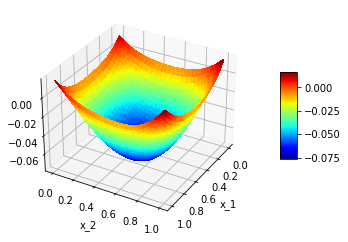

In [11]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=omega,
                                       n_points=2000)
fig = tp.utils.plot(model, lambda u : u, plot_sampler)

## Example 2
Now, we make the problem a little bit more complicated and try to solve:

\begin{align*}
    D \Delta u &= 1 &&\text{ in } \Omega \\
    u &= 0 , &&\text{ on } \partial \Omega
\end{align*}

with $\Omega = [0, 1] \times [0, 1]$ and $D \in [0.1, 1.0]$.

In [12]:
import torchphysics as tp
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')
D = tp.spaces.R1('D')

In [13]:
omega = tp.domains.Parallelogram(X, [0,0], [1,0], [0,1])
I_D = tp.domains.Interval(D, 0.1, 1.0)

In [14]:
inner_sampler = tp.samplers.RandomUniformSampler(omega*I_D, n_points=15000)

bound_sampler = tp.samplers.GridSampler(omega.boundary, n_points=200) \
                * tp.samplers.GridSampler(I_D, n_points=50)

In [15]:
model = tp.models.FCN(input_space=X*D, output_space=U, hidden=(20,20,20))

In [16]:
def pde_residual(D, u, x):
    return D*tp.utils.laplacian(u, x) - 1.0

pde_cond = tp.conditions.PINNCondition(model, inner_sampler, pde_residual)

In [17]:
def boundary_residual(u, x):
    return u - 0.0

boundary_cond = tp.conditions.PINNCondition(model, bound_sampler, boundary_residual, weight=50.0)

In [18]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([boundary_cond, pde_cond], optimizer_setting=optim)

In [20]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, # use one GPU
                     max_steps=5000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False) # saving checkpoints
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 941   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
941       Trainable params
0         Non-trainable params
941       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

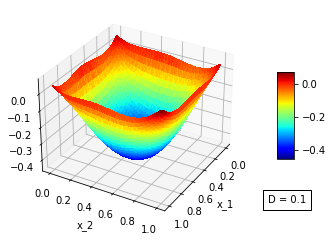

In [24]:
D_test = 0.1
plot_sampler = tp.samplers.PlotSampler(plot_domain=omega,
                                       n_points=2000, data_for_other_variables={'D': D_test})
fig = tp.utils.plot(model, lambda u : u, plot_sampler)